In [2]:
import tensorflow as t
import matplotlib.pyplot as plot
import numpy as np
import os

In [ ]:
fname = os.path.join("C:\\Users\\USER\\Documents\\datasets\\Our cleaned data2.csv")
with open(fname) as f:
 data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header) 
print(len(lines))

['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'precipprob', 'windspeed', 'winddir']
4568


In [4]:
models = {
    "raine" : ("raine", 6),
    "ember" : ("ember", 2), #this is an lstm model with simple training parameters friend.
    "mist" : ("mist", 4),
}

#change this variable to determine the model which we wish to train in this notebook
model_name, target_index = models["ember"]


In [5]:

target = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    target[i] = values[target_index]
    raw_data[i, :] = values[:]


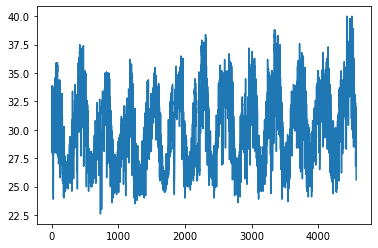

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(target)), target)

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(len(raw_data) == num_test_samples + num_train_samples + num_val_samples)
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

print(raw_data[num_train_samples + num_test_samples])



True
num_train_samples: 2284
num_val_samples: 1142
num_test_samples: 1142
[ 22.   26.6  29.4  88.2  11.  100.   34.1 238.5]


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
sampling_rate = 6
sequence_length = 7
delay = 7
batch_size = 256

train_dataset = t.keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets = target[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)

val_dataset = t.keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets = target[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = t.keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets = target[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 7, 8)
targets shape: (256,)


In [10]:
#now, we define different models depending on the model which we wish to train

inputs = inputs = t.keras.layers.Input(shape=(sequence_length, raw_data.shape[-1]))#independent of the model

#if model_name == "ember":
inputs = t.keras.layers.Input(shape=(sequence_length, raw_data.shape[-1]))
x = t.keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = t.keras.layers.Dropout(0.5)(x)
outputs = t.keras.layers.Dense(1)(x)
model = t.keras.Model(inputs, outputs)


callbacks = [
 t.keras.callbacks.ModelCheckpoint(f"..\\models\\{model_name}.keras",
 save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
train_dataset,
 epochs= 80,
 validation_data=val_dataset,
 callbacks = callbacks
 )
#callbacks=callbacks

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - loss: 868.7863 - mae: 29.3112 - val_loss: 920.0797 - val_mae: 30.1559
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 857.1039 - mae: 29.1178 - val_loss: 893.5123 - val_mae: 29.7171
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 832.7504 - mae: 28.6949 - val_loss: 854.6025 - val_mae: 29.0601
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 795.4311 - mae: 28.0368 - val_loss: 803.4224 - val_mae: 28.1670
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 749.7767 - mae: 27.2129 - val_loss: 741.7463 - val_mae: 27.0489
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 691.2181 - mae: 26.1040 - val_loss: 674.8072 - val_mae: 25.7793
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 631.6510 - mae: 24.9286 - val_loss: 610.9506 - val_mae: 24.5052
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 573.0469 - mae: 23.7151 - val_loss: 558.8885 - val_mae: 23.4105
Epoch 9/80
9/9 ━━━━━━━━━━━━━

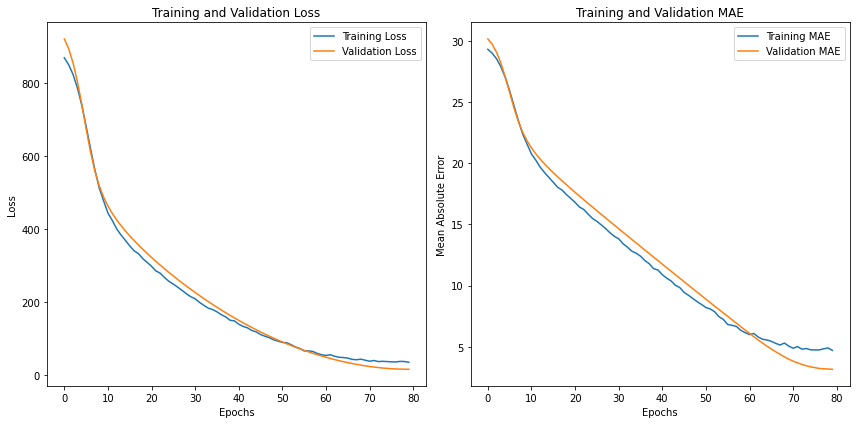

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')    
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
#Now this thing friends inside of this place pal and ladies and gentlemen of the jury friends inside
model.predict(test_dataset[0])

TypeError: '_BatchDataset' object is not subscriptable